In [ ]:
%config Completer.use_jedi = False

In [ ]:
# !pip install transformers ipywidgets

# import required lib

In [1]:
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import lightning.pytorch as pl
from torchvision.models import vgg11_bn, VGG11_BN_Weights
from torchmetrics import Accuracy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from lightning.pytorch.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import StepLR


torch.set_float32_matmul_precision("medium")

# classed in CIFAR10

In [2]:
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
logger = TensorBoardLogger("tb_logs", name="my_model_vgg") # setting up logged

# image transformation rules before feeing in network

In [4]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
])

In [5]:
batch_size=128

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create the train, validation, and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Load the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
imgs, labels = next(iter(train_loader))

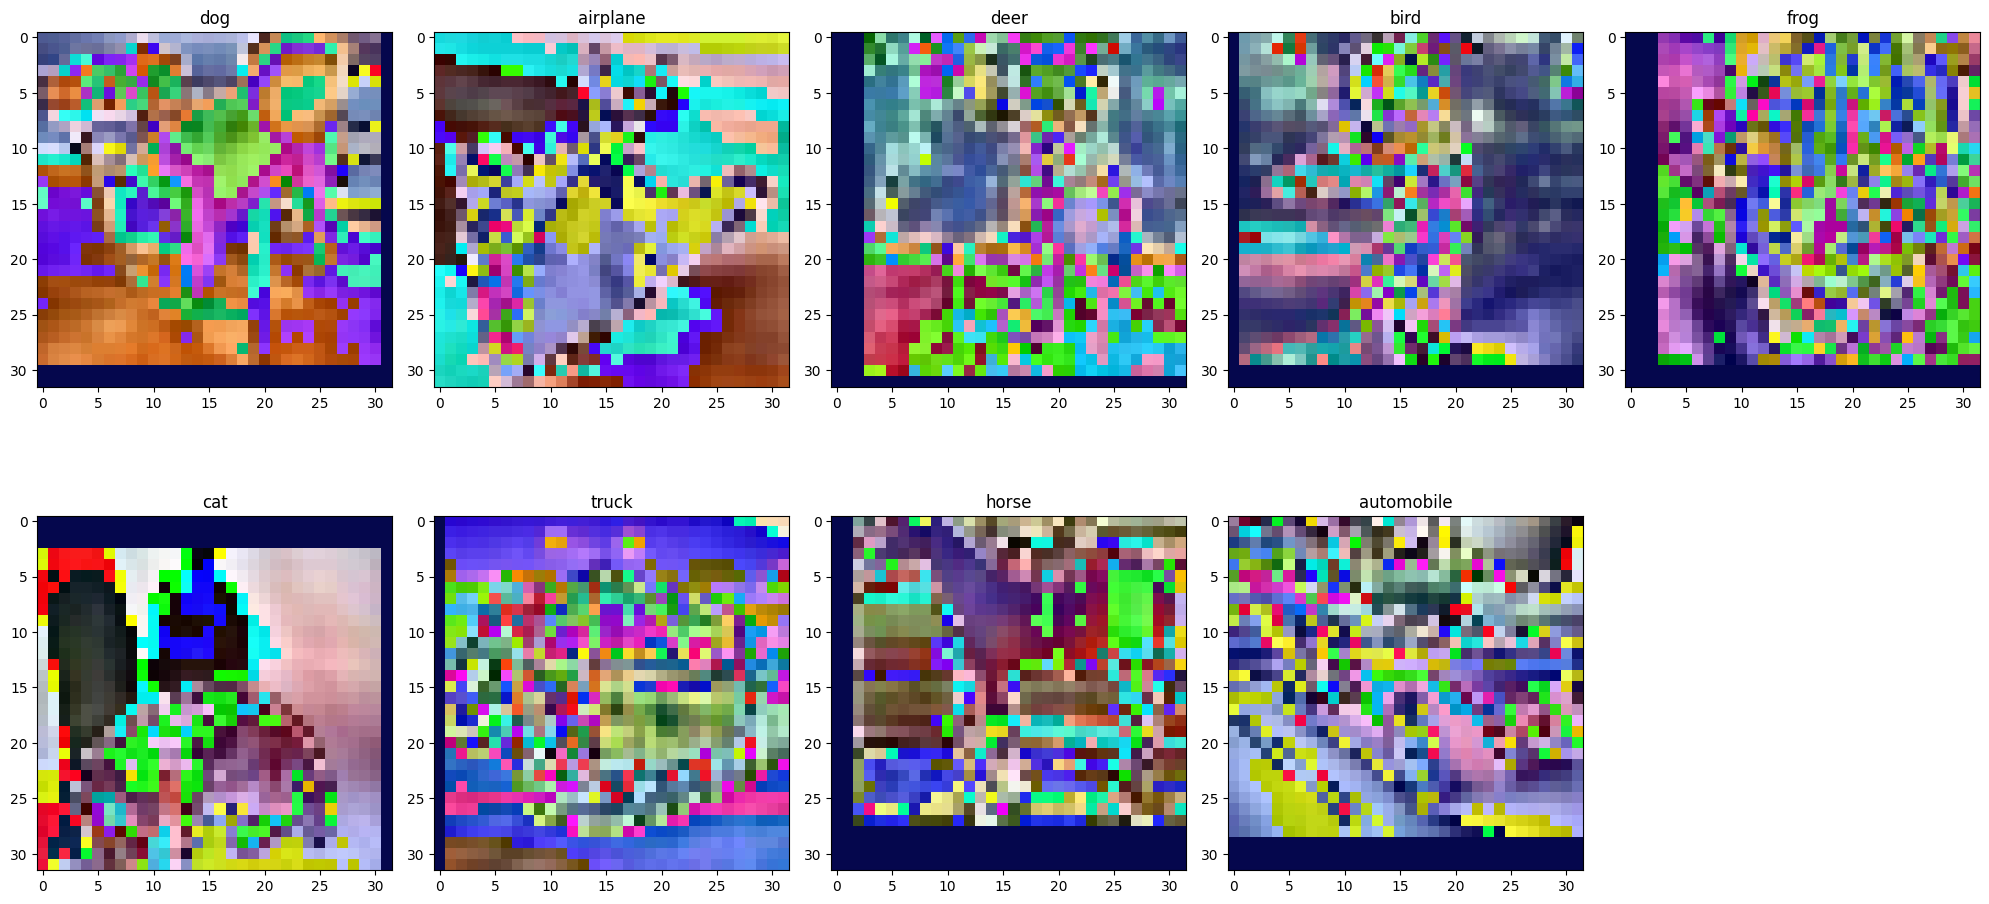

In [8]:

# Create a figure and axes
plt.figure(figsize=(10*2, 5*2))

# Iterate over the images and labels
for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(2, 5, i + 1)

    # Display the image
    plt.imshow(transforms.ToPILImage()(img))
    # Add the label
    plt.title(CLASS_NAMES[label])
    if i == 8:
        break

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
imgs.shape

torch.Size([128, 3, 32, 32])

# base vgg11 model

In [11]:
m = vgg11_bn(weights=VGG11_BN_Weights.DEFAULT)

In [12]:
m

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

# creating custom model using VGG arch

In [14]:
class RCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(RCNN, self).__init__()
        # Load the pre-trained ResNet-50 model
        self.m = vgg11_bn(weights=VGG11_BN_Weights.DEFAULT)
        # Remove the last layer
        del self.m.classifier[-1]
        # Add a custom fully connected layer
        fc_layer_1 = nn.Linear(4096, 1000)
        classifier = nn.Linear(1000, num_classes)
        relu_activation = nn.ReLU(inplace=True)
        self.m.classifier.add_module("fc_1_rcnn_added", fc_layer_1)
        self.m.classifier.add_module("relu_added", relu_activation)
        self.m.classifier.add_module("classifier_rcnn_added", classifier)
    def forward(self, x):
        x = self.m(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)
        return x

# creating pytorch lightning class using custom model

In [15]:
class LightningRCNN(pl.LightningModule):
    def __init__(self, num_classes:int) -> None:
        super().__init__()
        self.model = RCNN(num_classes=num_classes)
        self.loss_module = nn.CrossEntropyLoss()
        self.save_hyperparameters()
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        
        
    def forward(self, x):
        y = self.model(x)
        return y
    
    def training_step(self, batch, batch_idx):
       imgs, labels = batch
       preds = self.model(imgs)
       loss = self.loss_module(preds, labels)
       acc = self.accuracy(preds, labels)
       self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
       return loss
    
    def backward(self, loss):
        loss.backward()
    
    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)

        loss = self.loss_module(preds, labels)
        acc = self.accuracy(preds, labels)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        return {'validation_loss': loss, 'validation_accuracy': acc}

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs)
        acc = self.accuracy(preds, labels)
        loss = self.loss_module(preds, labels)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        return {'test_loss': loss, 'test_accuracy': acc}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        lr_scheduler = StepLR(optimizer, step_size=100, gamma=0.1)  # Define your scheduler
        return [optimizer], [lr_scheduler]
        

In [16]:
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint , LearningRateMonitor 


# some basic rule to prevent overfitting of model
### 1. adding early stopping
### 2. save top 2 model with best validation_accuracy

In [17]:
early_stop_callback = EarlyStopping(monitor="validation_accuracy", mode="max")
checkpoint_callback = ModelCheckpoint(dirpath="model_v1_vgg/", save_top_k=2, monitor="validation_accuracy", mode="max")
lr_monitor = LearningRateMonitor(logging_interval='step')

In [18]:
trainer = pl.Trainer(accelerator="gpu", enable_checkpointing=True, max_epochs=30, logger=logger, callbacks=[early_stop_callback, checkpoint_callback, lr_monitor])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
model = LightningRCNN(num_classes=10)

In [20]:
model

LightningRCNN(
  (model): RCNN(
    (m): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (12): BatchNorm2d(256, eps=1e-05, momentu

In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
test_result = trainer.test(model, dataloaders=test_loader, verbose=False)

In [ ]:
test_result